In [1]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Directories for the images
benign_dir = "/content/drive/MyDrive/benignsegmented_final_SegNet_GA"
malignant_dir = "/content/drive/MyDrive/malignantsegmented_final_SegNet_GA"

# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to 128x128
            images.append((img, label))  # Append image and its label as tuple
    return images

# Load images
benign_images = load_images_from_folder(benign_dir, 0)  # Label 0 for benign
malignant_images = load_images_from_folder(malignant_dir, 1)  # Label 1 for malignant

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, specificity, f1_score

# Data Augmentation
def augment_images(images, label):
    augmented_images = []
    for img, _ in images:
        # Horizontal flip
        flipped_img = cv2.flip(img, 1)
        augmented_images.append((flipped_img, label))

        # Rotation
        (h, w) = img.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, 15, 1.0)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h))
        augmented_images.append((rotated_img, label))

        # Brightness adjustment
        brightness_img = cv2.convertScaleAbs(img, alpha=1.1, beta=30)
        augmented_images.append((brightness_img, label))

        # Gaussian blur
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
        augmented_images.append((blurred_img, label))

        # Contrast adjustment
        contrast_img = cv2.convertScaleAbs(img, alpha=1.5, beta=0)
        augmented_images.append((contrast_img, label))

    return augmented_images

# Apply augmentation to both benign and malignant images
augmented_benign_images = augment_images(benign_images, 0)  # Label 0 for benign
augmented_malignant_images = augment_images(malignant_images, 1)  # Label 1 for malignant

# Combine original and augmented images
data = benign_images + augmented_benign_images + malignant_images + augmented_malignant_images
X, y = zip(*data)  # Unzip the list of tuples into separate lists
X = np.array(X)
y = np.array(y)

# Flatten the images for the classifier
X_flat = X.reshape(X.shape[0], -1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)



In [3]:
# Normalize images for VGG-16
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X = X / 255.0  # Scale pixel values to [0, 1]

# Reshape X to 128x128x3 for VGG-16 input (duplicate channels if grayscale)
X_reshaped = np.repeat(X, 3, axis=-1) if X.shape[-1] == 1 else X

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)


Epoch 1/50
495/495 [==============================] - 81s 161ms/step - loss: 0.5109 - accuracy: 0.7577 - val_loss: 0.4782 - val_accuracy: 0.7665
Epoch 2/50
495/495 [==============================] - 77s 155ms/step - loss: 0.4408 - accuracy: 0.7960 - val_loss: 0.4183 - val_accuracy: 0.8041
Epoch 3/50
495/495 [==============================] - 77s 155ms/step - loss: 0.3718 - accuracy: 0.8344 - val_loss: 0.3507 - val_accuracy: 0.8491
Epoch 4/50
495/495 [==============================] - 77s 155ms/step - loss: 0.2879 - accuracy: 0.8804 - val_loss: 0.4262 - val_accuracy: 0.8064
Epoch 5/50
495/495 [==============================] - 78s 157ms/step - loss: 0.2146 - accuracy: 0.9163 - val_loss: 0.3756 - val_accuracy: 0.8719
Epoch 6/50
495/495 [==============================] - 77s 156ms/step - loss: 0.1565 - accuracy: 0.9397 - val_loss: 0.4063 - val_accuracy: 0.8661
Epoch 7/50
495/495 [==============================] - 77s 156ms/step - loss: 0.1233 - accuracy: 0.9562 - val_loss: 0.2982 - val_ac

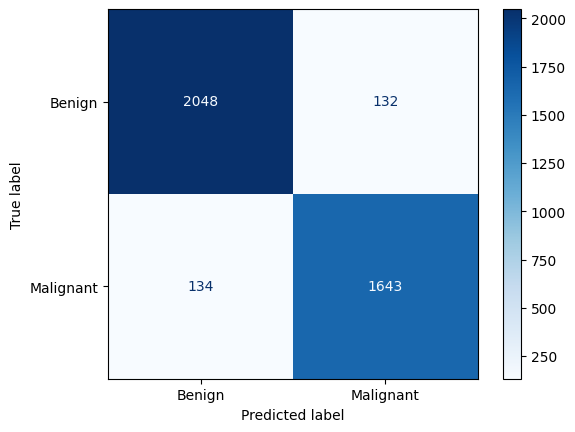

124/124 [==============================] - 4s 29ms/step - loss: 0.5814 - accuracy: 0.9328
Test Loss: 0.5814
Test Accuracy: 0.9328


In [ ]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define AlexNet model architecture
model = Sequential([
    Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    BatchNormalization(),

    Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),

    Dense(4096, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
                    batch_size=32)

# Predict and calculate metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Function to manually calculate metrics
def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate precision, recall, specificity, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, specificity, f1_score

# Calculate and display metrics
precision, recall, specificity, f1_score = calculate_metrics(y_test, y_pred)

print("Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
